In [1]:
import time, os, json
import numpy as np
from pandas import HDFStore, DataFrame
import tables
import matplotlib.pyplot as plt

#from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

#from pong_rnn import PongRNN


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [8]:
# load data 

q_list = []
p_list = []
y_list = []

with HDFStore('data/data.h5') as store: 
    for k in store.keys(): 
        d = np.array(store[k])[0:-1,:]
        
        assert d.shape == (100,1026)
        
        q = d[0:-1,0:1024].reshape((d.shape[0]-1, 32, 32))
        p = d[1:,1024:1026]
        y = d[1:,0:1024].reshape((d.shape[0]-1, 32, 32))
        
        assert ((q.shape[0] == p.shape[0]) and (q.shape[0] == y.shape[0]))
        assert q.shape == (99,32,32)
        assert p.shape == (99,2)
        assert y.shape == (99,32,32)
        
        q = q[:96]
        p = p[:96]
        y = y[:96]
        
        q = q.reshape((8,-1,1,32,32))
        p = p.reshape((8,-1,2))
        y = y.reshape((8,-1,32,32))
        
        q_list.append(q)
        p_list.append(p)
        y_list.append(y)

q_train = np.concatenate(q_list[0:-50],axis=1)
p_train = np.concatenate(p_list[0:-50],axis=1)
y_train = np.concatenate(y_list[0:-50],axis=1)

q_val = np.concatenate(q_list[-50:],axis=1)
p_val = np.concatenate(p_list[-50:],axis=1)
y_val = np.concatenate(y_list[-50:],axis=1)

#q_train = np.expand_dims(q_train, axis=2)

# q_train = np.concatenate(q_train)
# q_train = q_train.reshape((q_train.shape[0],1,q_train.shape[1],q_train.shape[2]))


print q_train.shape
print p_train.shape
print y_train.shape

print q_val.shape
print p_val.shape
print y_val.shape


(8, 5400, 1, 32, 32)
(8, 5400, 2)
(8, 5400, 32, 32)
(8, 600, 1, 32, 32)
(8, 600, 2)
(8, 600, 32, 32)


In [186]:
import numpy_pong

data = []

for i in range(100000): 
    seq = numpy_pong.headless_mode(num_frames=9, 
                                   ballloc=(np.random.choice(np.arange(30)),np.random.choice(np.arange(24))+2))
    data.append(seq) 
    if (i+1) % 10000 == 0: print "%i sequences generated" % (i)

0 sequences generated
10000 sequences generated
20000 sequences generated
30000 sequences generated
40000 sequences generated
50000 sequences generated
60000 sequences generated
70000 sequences generated
80000 sequences generated
90000 sequences generated


In [188]:
q_list = []
p_list = []
y_list = []

#print data[0].shape # (10,1026)

for seq in data: 
    q = seq[0:8,0:1024].reshape(8,1,1,32,32)
    p = seq[0:8,1024:1026].reshape(8,1,2)
    y = seq[1:9,0:1024].reshape(8,1,32,32)
    
    q_list.append(q)
    p_list.append(p)
    y_list.append(y)
    
q_train = np.concatenate(q_list[0:-10000],axis=1)
p_train = np.concatenate(p_list[0:-10000],axis=1)
y_train = np.concatenate(y_list[0:-10000],axis=1)

q_val = np.concatenate(q_list[-10000:],axis=1)
p_val = np.concatenate(p_list[-10000:],axis=1)
y_val = np.concatenate(y_list[-10000:],axis=1)
    

In [189]:
for s in [q_train,p_train,y_train]: 
    print s.shape

(8, 90000, 1, 32, 32)
(8, 90000, 2)
(8, 90000, 32, 32)


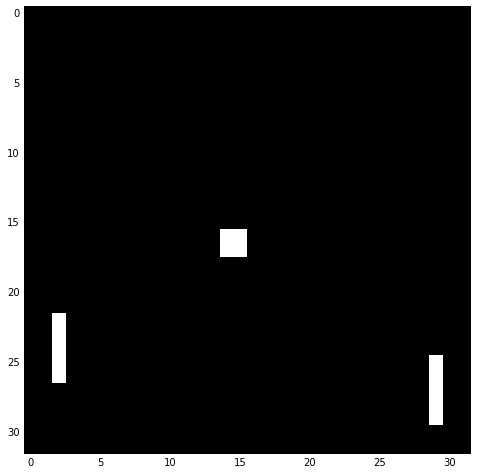

In [199]:
plt.imshow(q_train[5,0,0])

In [190]:
# load the RNN

from theano_pong_rnn import * 

model = PongRNNModel(8,512,32,32)

In [203]:
# train the model

#model = PongRNNModel(8,100,32,32)

i=0
epoch=0
alpha = 1
lr_decay = 0.995

while (True):
    if (i + 512 > q_train.shape[1]): 
        epoch += 1
        i = 0
        if epoch % 1 == 0: print "Loss after %i epochs: %f" % (epoch, loss)
        alpha = alpha * lr_decay
        
    q_batch = q_train[:,i:i+512].astype(np.float32)
    p_batch = p_train[:,i:i+512].astype(np.float32)
    y_batch = y_train[:,i:i+512].astype(np.float32) 
    
    loss = model.train(q_batch,p_batch,y_batch,alpha)
    if (i % (512*50) == 0): pass #print "Loss after %i batches: %f" % (i / 512, loss) 
    
    
    i = i + 512

Loss after 1 epochs: 0.291237
Loss after 2 epochs: 0.291278


KeyboardInterrupt: 

In [204]:
pred = model.predict(q_val[:,0:512].astype(np.float32),p_val[:,0:512].astype(np.float32))
y_val_batch = y_val[:,0:512].astype(np.float32)
print pred.shape

pred_over = model.predict(q_train[:,0:512].astype(np.float32),p_train[:,0:512].astype(np.float32))
print pred_over.shape


(8, 512, 32, 32)
(8, 512, 32, 32)


0.877963 0.0880615


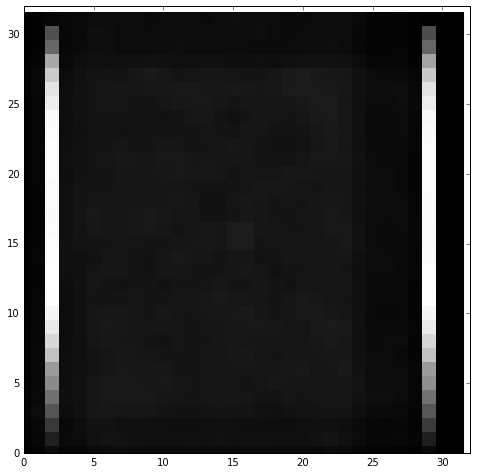

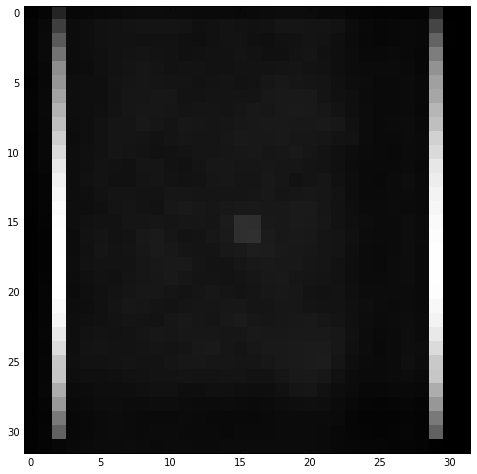

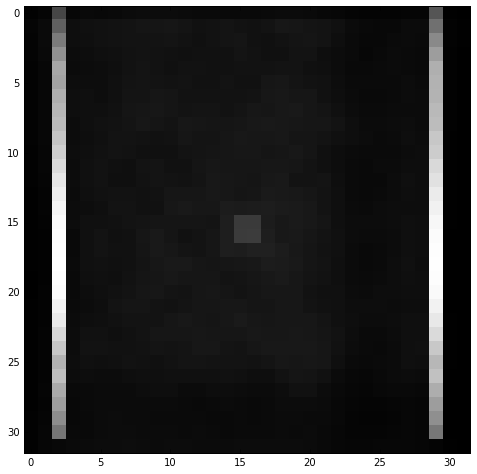

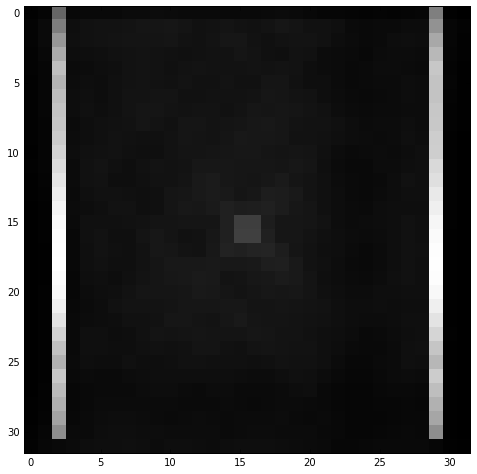

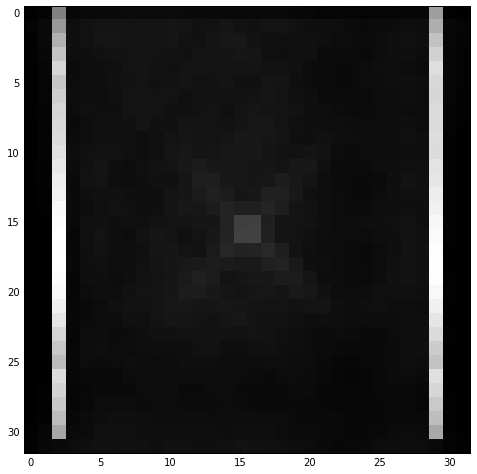

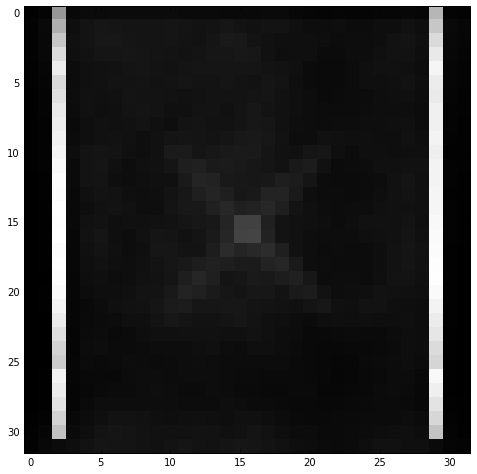

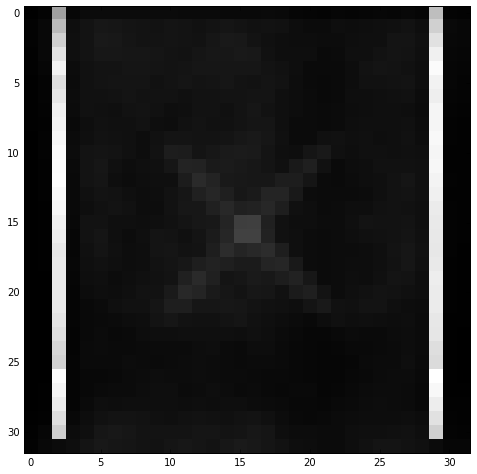

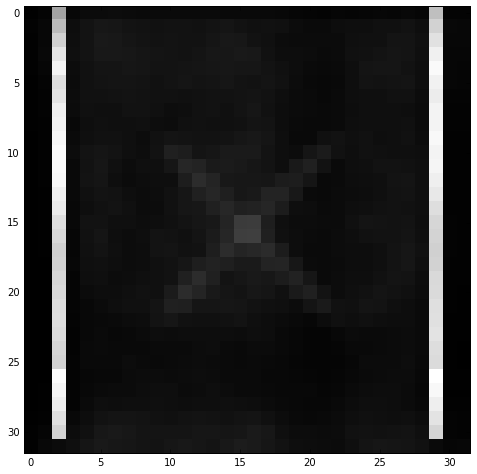

In [205]:
plt.axis([0,32,0,32])
plt.ion()

print pred.max(), pred.mean()
# print pred[0].sum()

for row in pred[:,0:1]:
    frame = row.reshape((32,32))
    #frame = np.where(frame > 0.1, 1, 0)
    plt.imshow(frame)
    plt.draw()
    plt.show()
    plt.pause(0.01)

In [48]:
# test code for saving weights

from six.moves import cPickle

with open('weights/rnn_weights.save','wb') as f: 
    cPickle.dump(model.params, f, protocol=cPickle.HIGHEST_PROTOCOL)
    


In [53]:
import subprocess

subprocess.call("aws s3 sync /home/ubuntu/pong_rnn/weights s3://model-checkpoints",shell=True)

0

In [175]:
print np.zeros(1)

[ 0.]


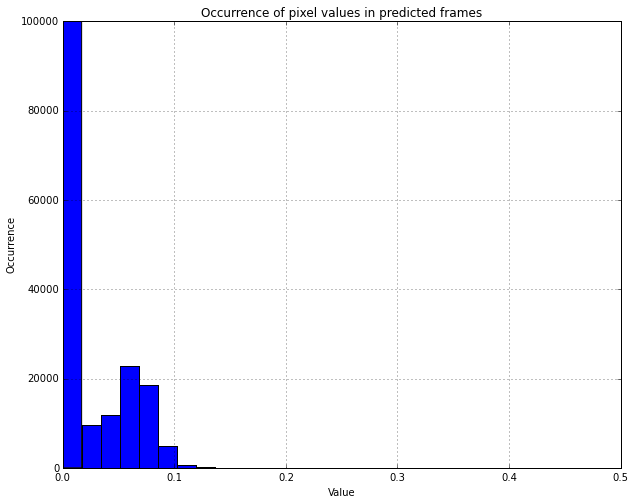

In [148]:
# visualize histogram of values in predicted frames

n, bins, patches = plt.hist(y_pred['screen_out'].flatten(), 10, facecolor='blue')
plt.xlabel('Value')
plt.ylabel('Occurrence')
plt.title(r'Occurrence of pixel values in predicted frames')
plt.axis([0, 0.5, 0, 100000])
plt.grid(True)

plt.show()


In [151]:
# overfit small data

[[[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]]


[1 1]


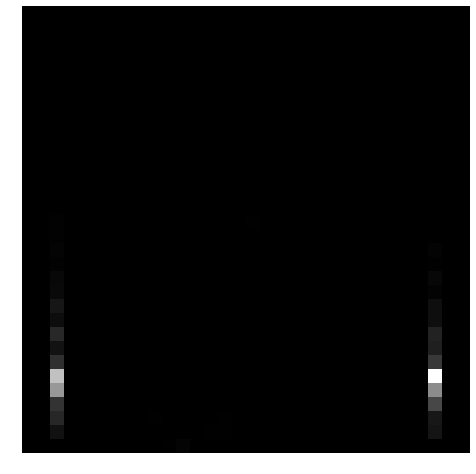

[-1 -1]


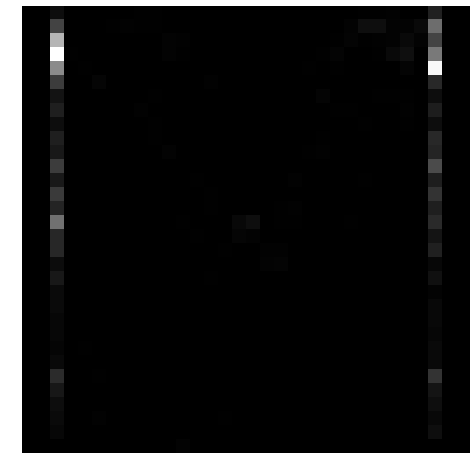

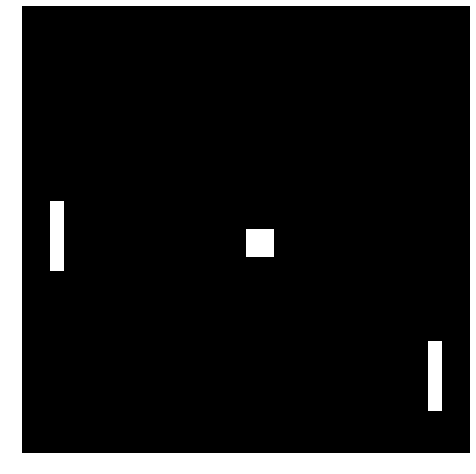

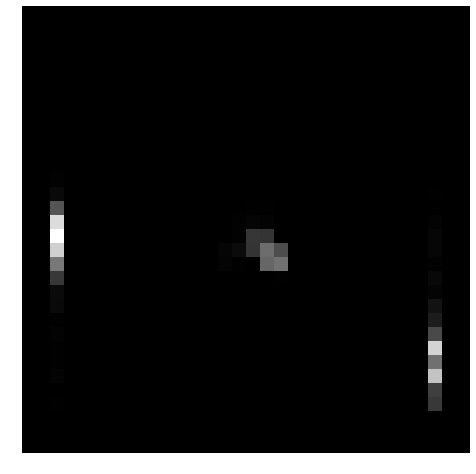

In [259]:
# Code for prediction with inputs -- 
#
# Results demonstrate that the model knows inputs control the paddles, although it doesn't know
# which inputs control which paddles (this is likely a data problem). 
#
# It also seems to grossly overestimate how fast the controls move the paddles, 
# and it either loses track of the ball or thinks the paddles move it or both. 


def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

frames = []

i = 0
q_0 = q_train[0]

input_possibilities = [
#    np.array([0,0]),
    np.array([1,1]),
#    np.array([1,-1]),
    np.array([-1,-1]),
#    np.array([-1,1]),
]

# imshow_noax(q_0.reshape((32,32)))
# plt.draw()
# plt.show()



for p in input_possibilities: 
    print p
    q = q_0.copy().reshape((1,1,32,32))
    q_tote = np.zeros((32,32))
    for j in range(100):
        p = np.array(p).reshape(1,2)
        
        q = model.predict(q.reshape((1,1,32,32)),p,batch_size=1)['screen_out']
        q_tote += q.reshape((32,32))
    
    imshow_noax(q_tote)
    plt.draw()
    plt.show()
        

imshow_noax(q_0.reshape((32,32)))
plt.draw()
plt.show()

q_diff = np.abs(q_0.reshape((32,32)) + 32*q_1.reshape((32,32)))
imshow_noax(q_diff, normalize=True)

plt.draw()
plt.show()

(25, 32, 32, 1)


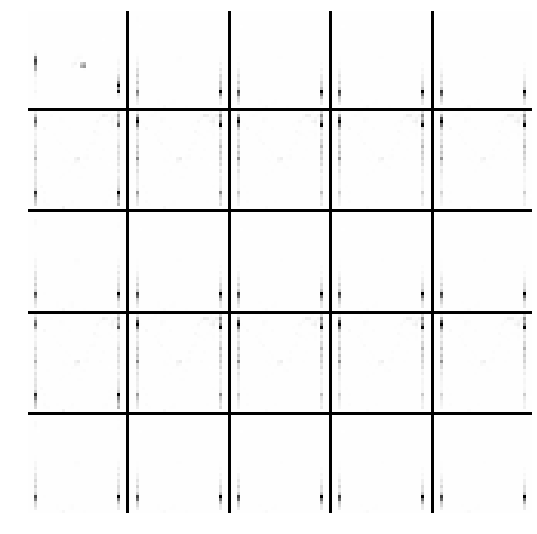

In [200]:

from cs231n.vis_utils import visualize_grid


frames = []

i = 0
q = q_train[0]
p = np.array([[1,1],[1,1],[1,1],[1,1],[1,1],[-1,-1],[-1,-1],[-1,-1],[-1,-1],[-1,-1]])
p = p.reshape((10,1,2))

while (i < 25): 
    q = q.reshape(1,1,32,32)
    q = model.predict(q,p[i % 10,:],batch_size=99)['screen_out']
    frames.append(-1*q.reshape(32,32,1))
    i += 1


frames = np.array(frames)
print frames.shape

grid = visualize_grid(frames)
grid = grid.reshape((grid.shape[0],-1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(9, 9)
plt.show()

In [203]:
model.graph.evaluate({'screen_in': q_val, 'control_in': p_val, 'screen_out': y_val})

0.037313299641163665

In [213]:
# visualize model graph 

import pydot


def plot(model, to_file='model.png'):

    graph = pydot.Dot(graph_type='digraph')
#     if type(model) == Sequential:
#         previous_node = None
#         written_nodes = []
#         n = 1
#         for node in model.get_config()['layers']:
#             # append number in case layers have same name to differentiate
#             if (node['name'] + str(n)) in written_nodes:
#                 n += 1
#             current_node = pydot.Node(node['name'] + str(n))
#             written_nodes.append(node['name'] + str(n))
#             graph.add_node(current_node)
#             if previous_node:
#                 graph.add_edge(pydot.Edge(previous_node, current_node))
#             previous_node = current_node
#         graph.write_png(to_file)

#     elif type(model) == Graph:
    # don't need to append number for names since all nodes labeled
    for input_node in model.input_config:
        graph.add_node(pydot.Node(input_node['name']))

    # intermediate and output nodes have input defined
    for layer_config in [model.node_config, model.output_config]:
        for node in layer_config:
            graph.add_node(pydot.Node(node['name']))
            # possible to have multiple 'inputs' vs 1 'input'
            if node['inputs']:
                for e in node['inputs']:
                    graph.add_edge(pydot.Edge(e, node['name']))
            else:
                graph.add_edge(pydot.Edge(node['input'], node['name']))

    graph.write_png(to_file) 

plot(model, 'prototype-model.png')
 

AttributeError: 'PongRNN' object has no attribute 'input_config'

In [269]:
# utility functions -- from here: http://nbviewer.jupyter.org/github/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

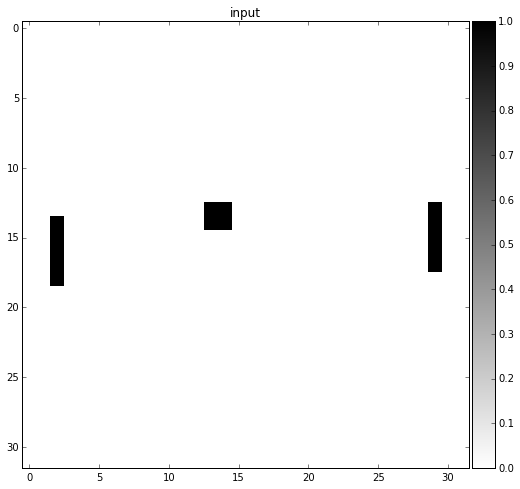

In [369]:
# Attempt to visualize hidden layer activations

X = [q_val[100], p_val[100]] 
plt.figure()
plt.title('input')
nice_imshow(plt.gca(), np.squeeze(X[0]), vmin=0, vmax=1, cmap=cm.binary)


In [425]:
from hidden_state_viz import get_hidden_f

indices = np.random.choice(np.arange(q_val.shape[0]), 9)
print indices

X = [q_val[indices,],p_val[indices,]]

q = X[0].astype(np.float32)
p = X[1].astype(np.float32)

control = model.graph.inputs['control_in']
screen = model.graph.inputs['screen_in']


H_f = get_hidden_f(control, screen, model.graph.nodes['RNN3'])


H_1 = H_f(q, p)
H_1 = np.squeeze(H_1)
print("Shape : ", H_1.shape)

indices = np.arange(9)


X = [q_val[indices,],p_val[indices,]]

q = X[0].astype(np.float32)
p = X[1].astype(np.float32)

H_2 = H_f(q, p)
H_2 = np.squeeze(H_2)


[2388 1570 4526 1182 4945  673 1350 1439 4789]
('Shape : ', (9, 512))


0.363647
0.313204
0.325981


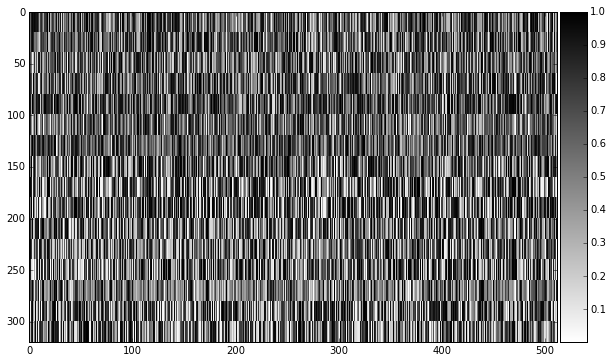

In [403]:
# FINALLY theano function compiles and (?) runs
# Now let's visualize some activations

H_diffs = (H_1[1:8] - H_1[0:7])
print np.mean(H_diffs)
print np.std(H_1)

print np.std(H_2)

H_viz = np.vstack([np.repeat(H_diffs, 20, axis=0), np.repeat(H_1, 20, axis=0)])

nice_imshow(plt.gca(), 1 - H_viz, cmap=cm.binary)

# H_viz = np.repeat(H_2, 20, axis=0)

#nice_imshow(plt.gca(), 1 - H_viz, cmap=cm.binary)


In [407]:
# extract + visualize RNN weights -- in particular, there should be some weights on the hidden state! 

RNN = model.graph.nodes['RNN3'] 
weights = RNN.get_weights()



3
[(16386, 512), (512, 512), (512,)]
[0.027271735, 0.048613552, 0.006966487]
0.212436 -0.208574


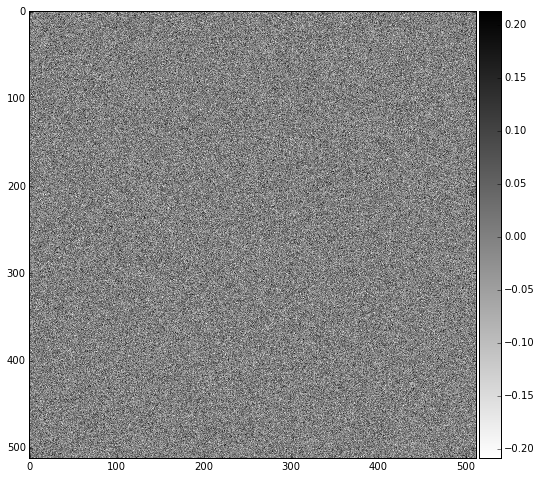

In [430]:
print len(weights)
print [w.shape for w in weights]
print [w.std() for w in weights]

print weights[1].max(), weights[1].min()

nice_imshow(plt.gca(), weights[1], cmap=cm.binary)

# weights[1] is the weights on the recurrent state -- these are the largest weights in the layer, although they look small to my eye. 

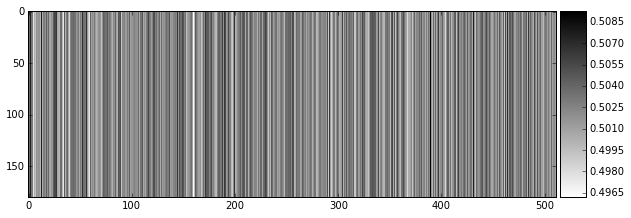

In [435]:
# try feeding the network some real frames and then some zero frames.
# Later activations should reflect some memory of earlier activations. 

# CONTROL: feed in all zeros

indices = np.arange(9)

X = [q_val[indices,],p_val[indices,]]

q = np.zeros_like(X[0]).astype(np.float32)
p = np.zeros_like(X[1]).astype(np.float32)


H_control = H_f(q, p)
H_control = np.squeeze(H_control)

# visualize control activations

H_viz = np.repeat(H_control, 20, axis=0)

nice_imshow(plt.gca(), 1 - H_viz, cmap=cm.binary)


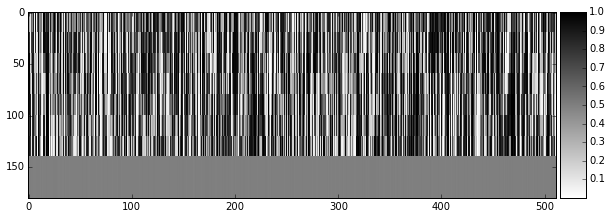

In [434]:
# EXPERIMENTAL: feed in real data followed by zeros

indices = np.arange(7)

X = [q_val[indices,],p_val[indices,]]

q = np.vstack([q_val[indices,], np.zeros_like(q_val[0:2])]).astype(np.float32)
p = np.vstack([p_val[indices,], np.zeros_like(p_val[0:2])]).astype(np.float32)


H_exp = H_f(q, p)
H_exp = np.squeeze(H_exp)

# visualize control activations

H_viz = np.repeat(H_exp, 20, axis=0)

nice_imshow(plt.gca(), 1 - H_viz, cmap=cm.binary)

In [2]:
# a final test: train a new model and see if the hidden-to-hidden weights get updated at all
from pong_rnn import PongRNN



model_2 = PongRNN()
W_hh_init = model_2.graph.nodes['RNN3'].get_weights()[1]
model_2.train(q_train, p_train, y_train, nb_epoch=1)
W_hh_trained = model_2.graph.nodes['RNN3'].get_weights()[1]

W_hh_delta = np.abs(W_hh_init - W_hh_trained)
print W_hh_delta.mean()

AttributeError: 'module' object has no attribute 'pack'

In [1]:
from theano_pong_rnn import *

In [2]:
model = PongRNNModel(8,32,32,32)

In [18]:
q_train = q_train.reshape(-1,8,1,32,32)
p_train = p_train.reshape(-1,8,2)
y_train = y_train.reshape(-1,8,32,32)

print q_train.shape
print p_train.shape
print y_train.shape

(5544, 8, 1, 32, 32)
(5544, 8, 2)
(5544, 8, 32, 32)


In [19]:
q_train = np.swapaxes(q_train,0,1)
p_train = np.swapaxes(p_train,0,1)
y_train = np.swapaxes(y_train,0,1)

In [20]:
print q_train.shape
print p_train.shape
print y_train.shape

(8, 5544, 1, 32, 32)
(8, 5544, 2)
(8, 5544, 32, 32)


In [45]:
q_batch = q_train[:,0:32,:,:,:]
p_batch = p_train[:,0:32,:]
y_batch = y_train[:,0:32,:,:]

print q_batch.shape
print p_batch.shape
print y_batch.shape


(8, 32, 1, 32, 32)
(8, 32, 2)
(8, 32, 32, 32)


In [26]:
model.train(q_batch,p_batch,y_batch,1e-2)

array(inf)

In [82]:
q_batch = q_batch.astype(np.float32)
p_batch = p_batch.astype(np.float32)
y_batch = y_batch.astype(np.float32)

In [83]:
model = PongRNNModel(8,32,32,32)

print np.sum([p.get_value().sum() for p in model.params])

119.686


In [84]:
sm =  model.print_y_softmax(q_batch,p_batch)
print np.where(sm == 0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [85]:
print model.train(q_batch,p_batch,y_batch,1e-2)

0.092893242836
